In [3]:
import json
import time
from typing import Dict

from datasets import load_dataset, load_from_disk# type: ignore
from datasets.formatting.formatting import LazyBatch # type: ignore
from huggingface_hub import list_datasets # type: ignore
import matplotlib.pyplot as plt
from minio import Minio
from minio.datatypes import Object
from minio.helpers import ObjectWriteResult
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import torch
from transformers import AutoModel, AutoTokenizer
from transformers.tokenization_utils_base import BatchEncoding

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from seaborn import set_style
import statsmodels as sm

Loading the dataset

In [33]:
data = load_from_disk('Merged_Close_feature_sp_date')
data

DatasetDict({
    train: Dataset({
        features: ['Date', 'Close', 'hidden_state'],
        num_rows: 222
    })
    validation: Dataset({
        features: ['Date', 'Close', 'hidden_state'],
        num_rows: 22
    })
    test: Dataset({
        features: ['Date', 'Close', 'hidden_state'],
        num_rows: 24
    })
})

Transforming to pandas data frame

In [34]:

ds_train = data['train']
ds_test = data['test']
ds_val = data['validation']

df_train = pd.DataFrame(ds_train)
df_test = pd.DataFrame(ds_test)
df_val = pd.DataFrame(ds_val)


    

In [35]:
df_train['Close_numeric']=np.nan
df_test['Close_numeric']=np.nan
df_val['Close_numeric']=np.nan
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 222 entries, 0 to 221
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           222 non-null    datetime64[ns]
 1   Close          209 non-null    object        
 2   hidden_state   222 non-null    object        
 3   Close_numeric  0 non-null      float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 7.1+ KB


In [40]:
print(df_test['Close'][0])

4,594.63


In [38]:
for i in range(0, len(df_train)):
    if df_train['Close'][i] != None:
        df_train['Close_numeric'][i] = float(df_train['Close'][i].replace(',', ''))

for i in range(0, len(df_test)):
    if df_test['Close'][i] != None:
        df_test['Close_numeric'][i] = float(df_test['Close'][i].replace(',', ''))
    
for i in range(0, len(df_val)):
    if df_val['Close'][i] != None:
        df_val['Close_numeric'][i] = float(df_val['Close'][i].replace(',', ''))

/var/folders/g7/0r52jtgn0lx64hw0zmgwgr2h0000gn/T/ipykernel_23728/2016532180.py:3: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_train['Close_numeric'][i] = float(df_train['Close'][i].replace(',', ''))
/var/folders/g7/0r52jtgn0lx64hw0zmgwg

In [24]:
df_val.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22 entries, 0 to 21
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           22 non-null     datetime64[ns]
 1   Close          21 non-null     object        
 2   hidden_state   22 non-null     object        
 3   Close_numeric  21 non-null     float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 836.0+ bytes


Treat missing values

In [41]:
df_train['Close_numeric'].interpolate(method='nearest', inplace=True)
df_test['Close_numeric'].interpolate(method='nearest', inplace=True)
df_val['Close_numeric'].interpolate(method='nearest', inplace=True)
# Other methods: 'polynomial', 'spline', 'quadratic'
#df_train['Close'].interpolate(method='polynomial', order=2, inplace=True)  # Polynomial interpolation of order 2


/var/folders/g7/0r52jtgn0lx64hw0zmgwgr2h0000gn/T/ipykernel_23728/3083625172.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_train['Close_numeric'].interpolate(method='nearest', inplace=True)
/var/folders/g7/0r52jtgn0lx64hw0zmgwgr2h0000gn/T/ipykernel_23728/3083625172.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we ar

In [46]:
type(df_train['Close_numeric'][0])

numpy.float64

In [43]:
df_train['Close_numeric'][0]=df_train['Close_numeric'][1]

/var/folders/g7/0r52jtgn0lx64hw0zmgwgr2h0000gn/T/ipykernel_23728/3778540147.py:1: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_train['Close_numeric'][0]=df_train['Close_numeric'][1]
/var/folders/g7/0r52jtgn0lx64hw0zmgwgr2h0000gn/T/ipyker

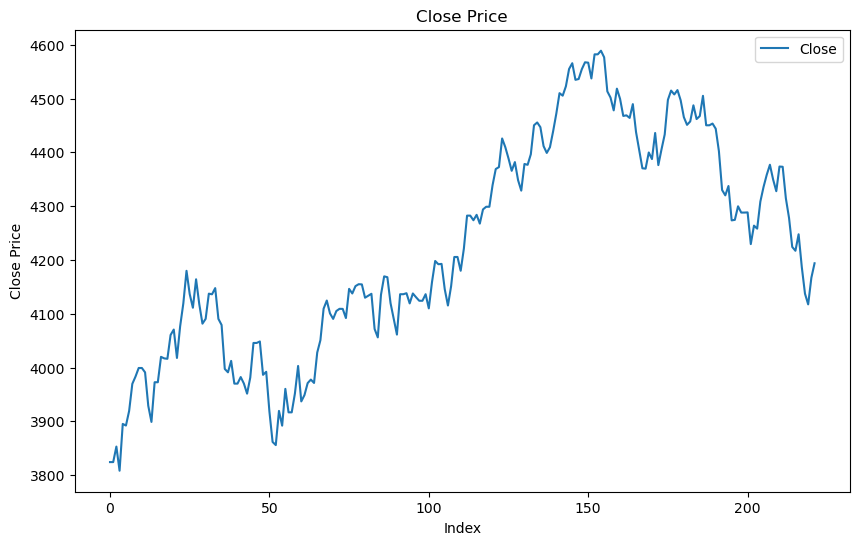

In [47]:
plt.figure(figsize=(10, 6))
plt.plot(np.arange(0,len(df_train['Close_numeric'])), df_train['Close_numeric'], label='Close')
plt.title('Close Price')
plt.xlabel('Index')
plt.ylabel('Close Price')
plt.legend()
plt.show()


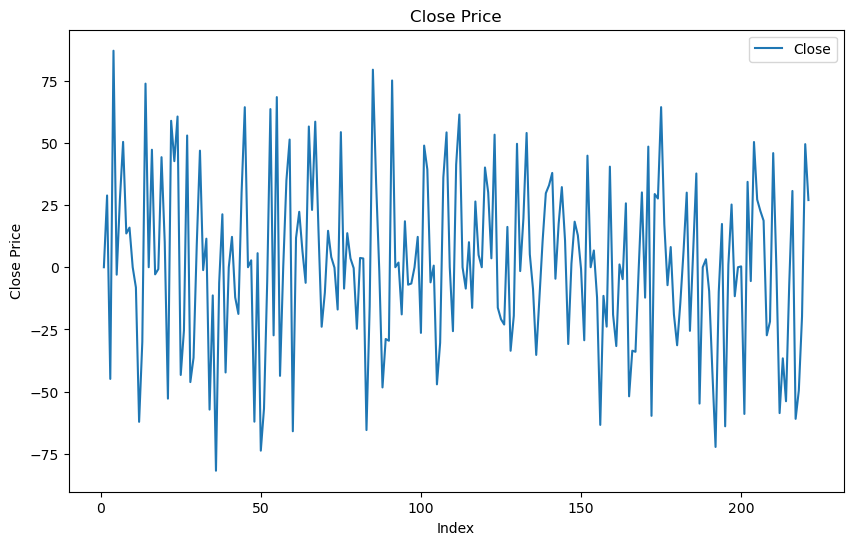

In [48]:
plt.figure(figsize=(10, 6))
plt.plot(np.arange(0,len(df_train['Close_numeric'])), df_train['Close_numeric'].diff(), label='Close')
plt.title('Close Price')
plt.xlabel('Index')
plt.ylabel('Close Price')
plt.legend()
plt.show()

Exponential Smoothing

In [49]:
from statsmodels.tsa.api import SimpleExpSmoothing
simp_exp_smooth = SimpleExpSmoothing(df_train.Close_numeric.values).fit(smoothing_level=.8,
                                                                             optimized=False)

In [50]:
df_train.columns

Index(['Date', 'Close', 'hidden_state', 'Close_numeric'], dtype='object')

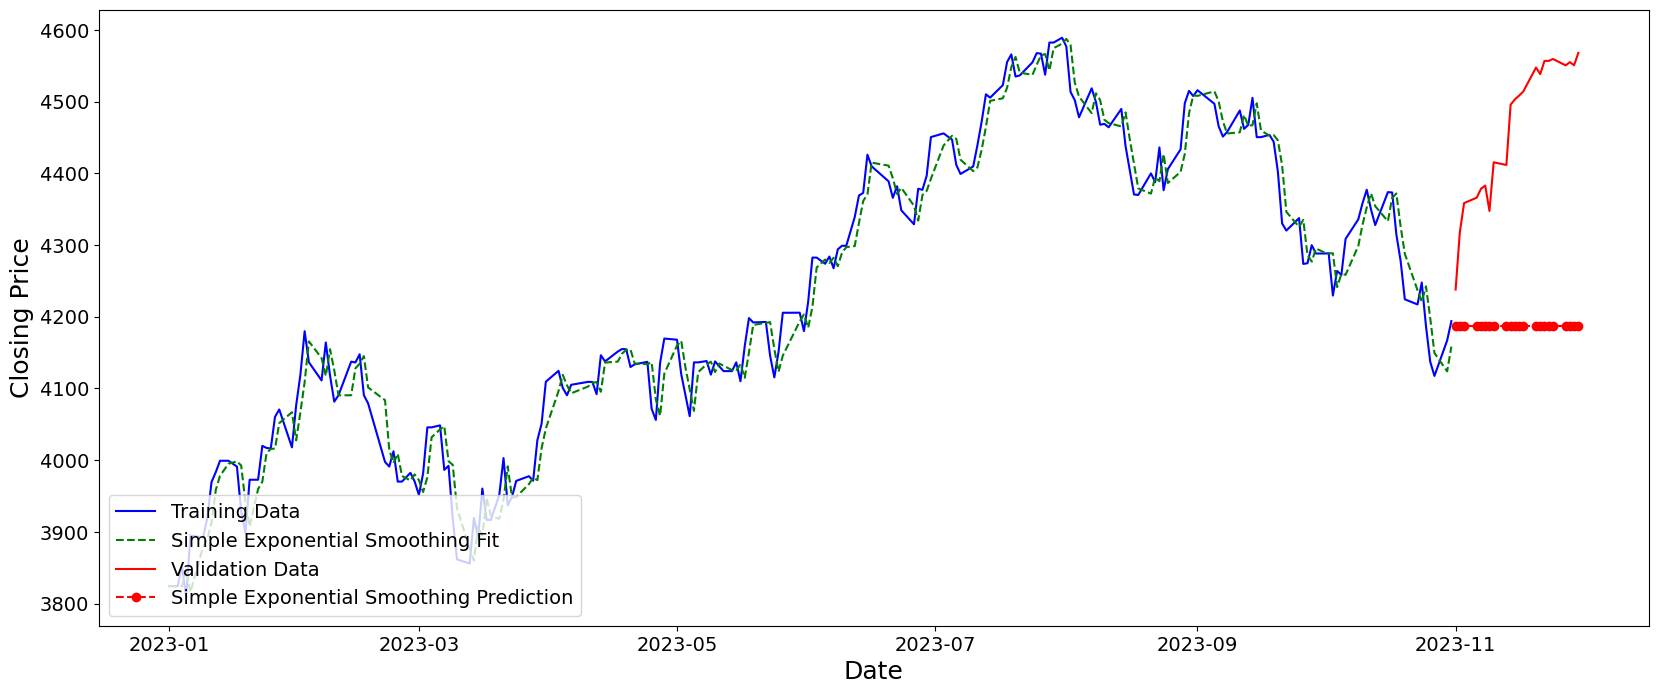

In [51]:
plt.figure(figsize=(20,8))


plt.plot(df_train.Date, 
         df_train.Close_numeric,
         'b',
         label="Training Data")


## We can get the fitted values with fittedvalues
plt.plot(df_train.Date, 
         simp_exp_smooth.fittedvalues,
         'g--',
         label="Simple Exponential Smoothing Fit")

plt.plot(df_val.Date, 
         df_val.Close_numeric,
         'r',
         label="Validation Data")

## We can get the forecast with .forecast(h)
plt.plot(df_val.Date, 
         simp_exp_smooth.forecast(len(df_val)),
         'r--o',
         label="Simple Exponential Smoothing Prediction")

plt.xlabel("Date", fontsize=18)
plt.ylabel("Closing Price", fontsize=18)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.legend(fontsize=14, loc=3)

plt.show()

In [52]:
# This function takes 3 numpy arrays as inputs.
# It returns the 
# mean absolute error of the forecast on the test set 
# relative to the
# mean absolute error of the naive forecast on the training set over an equivalent horizon.
# 
# If MASE > 1 then your forecast performs worse out of sample than naive forecast does in sample.
# If MASE < 1 then your forecast performs better out of sample than naive forecast does in sample.

def mase(y_train, y_test, y_preds):
    n = len(y_train)
    m = len(y_test)
    denom = 0
    for i in range(n-m):
        denom += np.abs(y_train[i+1:i+m+1] - y_train[i]*np.ones(m)).mean()
    denom = denom / (n-m)
    num = np.abs(y_test - y_preds).mean()
    return num/denom

# Example calculation

print('MASE = ', mase(y_train = np.array([1,2,3,4,5]), y_test = np.array([6,7]), y_preds = np.array([3, 3])))


MASE =  2.3333333333333335


In [53]:
df_train_val=pd.concat([df_train, df_val], axis=0, ignore_index=True)

22

In [82]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

cv = TimeSeriesSplit(n_splits=10, test_size=len(df_val))

ra_mase = np.zeros((10, 10))
rmse = np.zeros((10, 10))

i = 0
for train_index, test_index in cv.split(df_train_val):
    df_tt = df_train_val.iloc[train_index].copy()# your code here
    df_ho = df_train_val.iloc[test_index].copy()# your code here
    
    j = 0
    for alpha in np.linspace(0.1, 1,10):
        simp_exp_smooth = SimpleExpSmoothing(df_train_val.Close_numeric.values).fit(smoothing_level=alpha,
                                                                             optimized=False)
        pred = simp_exp_smooth.forecast(len(df_ho))
        
        ra_mase[i,j] = mase(df_tt.Close_numeric.values,df_ho.Close_numeric.values,pred)# your code here
        rmse[i,j]=np.sqrt(mean_squared_error(pred,df_ho.Close_numeric.values))

        j = j + 1
    i = i + 1

with diff

In [83]:
cv = TimeSeriesSplit(n_splits=10, test_size=len(df_val))

ra_mase = np.zeros((10, 10))
rmse = np.zeros((10, 10))

i = 0
for train_index, test_index in cv.split(df_train_val):
    df_tt = df_train_val.iloc[train_index].copy()# your code here
    df_ho = df_train_val.iloc[test_index].copy()# your code here
    
    j = 0
    for alpha in np.linspace(0.1, 1,10):
        simp_exp_smooth = SimpleExpSmoothing(df_train_val.Close_numeric.diff()).fit(smoothing_level=alpha,
                                                                             optimized=False)
        pred = simp_exp_smooth.forecast(len(df_ho))
        
        ra_mase[i,j] = mase(df_tt.Close_numeric.diff(),df_ho.Close_numeric.diff(),pred.cumsum())# your code here
        rmse[i,j]=np.sqrt(mean_squared_error(pred.cumsum(),df_ho.Close_numeric))

        j = j + 1
    i = i + 1

ValueError: Input contains NaN.

In [62]:
jstar=np.mean(ra_mase, axis=0).argmin()

In [76]:
np.mean(rmse, axis=0)

array([239.96565774, 281.19780912, 292.65979945, 296.16523387,
       297.86425819, 299.2117475 , 300.54985915, 301.94740081,
       303.41071714, 304.94217798])

In [63]:
jstar

0

In [64]:
np.mean(ra_mase, axis=0)

array([2.24110611, 2.6458046 , 2.76156094, 2.7984433 , 2.81663847,
       2.83112979, 2.84548455, 2.8604403 , 2.87610208, 2.89272445])

Rolling Average

In [77]:
cv = TimeSeriesSplit(n_splits=10, test_size=len(df_val))

start = 1
end = 30
ra_mase = np.zeros((10, len(range(start, end))))
rmse=np.zeros((10, len(range(start, end))))

i = 0
for train_index, test_index in cv.split(df_train_val):
    df_tt = df_train_val.iloc[train_index]
    df_ho = df_train_val.iloc[test_index]
    
    j = 0
    for q in range(start, end):
        pred = df_tt.Close_numeric[-q:].mean() * np.ones(len(df_ho))
        
        ra_mase[i,j] = mase(df_tt.Close_numeric.values, df_ho.Close_numeric.values, pred)
        
        rmse[i,j]=np.sqrt(mean_squared_error(df_tt.Close_numeric[-q:].mean() * np.ones(len(df_ho)),df_ho.Close_numeric.values))

        j = j + 1
    i = i + 1



In [70]:
jstar=np.mean(ra_mase, axis=0).argmin()

In [71]:
jstar

0

In [72]:
np.mean(ra_mase, axis=0)

array([1.10137201, 1.1548594 , 1.17514097, 1.18776956, 1.1986036 ,
       1.2109062 , 1.22360849, 1.22392067, 1.20799248, 1.19763989,
       1.1960128 , 1.20460158, 1.21049912, 1.22437136, 1.2345346 ,
       1.24661588, 1.25778583, 1.26645906, 1.27182768, 1.27890403,
       1.28973861, 1.30398084, 1.31848844, 1.33586331, 1.3441667 ,
       1.35446774, 1.3646899 , 1.37608022, 1.38909262])

In [78]:
np.mean(rmse, axis=0)

array([115.55755351, 119.03936094, 120.17425327, 121.19897208,
       121.95700598, 122.99176761, 124.17865807, 124.03326898,
       122.81037777, 122.07963085, 122.43239145, 123.66184696,
       124.50366567, 126.20257612, 127.41991977, 128.76910858,
       129.97542519, 131.25064076, 132.38540281, 133.3662864 ,
       134.78745453, 136.30327313, 137.85988833, 139.52978558,
       140.19332543, 140.97175106, 141.65463496, 142.47905402,
       143.50173487])